# Introduction to Explanability Methods for Machine- & Deep Learning
## GRAD-E1394 Deep Learning - Assignment 3
Authors:
*   Benjamin Adoba Ayida ([Github](https://github.com/benjaminayida))
*   Padmavathi Narayana Reddy, ([Github](https://github.com/padmabareddy))
*   Luis Windpassinger, ([Github](https://github.com/lwndp))
*   Franco Bastida, ([Github](https://github.com/francobastida))

# Table of Contents


*   [Memo](#memo)
*   [Overview](#overview)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#dataset)
*   [Model](#modeling)
*   [xAI Methods](#xai-methods)
*   [Conclusion & Limitations](#conclusion)
*   [References](#references)

<a name="memo"></a>
# Memo



**Subject:** Interpretability methods for deep learning in public policy contexts

**Introduction:**

This memo explains why interpretability and explainable AI (XAI) are essential when using machine-learning models in public-policy contexts

**Why explainability matters:**
Across government, automated decision-making systems are increasingly used for critical decisions, such as allocating social benefits, predicting recidivism, triaging medical cases, identifying fraud, and evaluating social program eligibility. Machine- and deep learning offer strong predictive performance but are often opaque, making it difficult to understand why a particular citizen is flagged as high risk, ineligible and so on. In loan-approval contexts, for example, citizens may be denied credit based on complex interactions of features that neither applicants nor case officers can interpret.

Regulatory frameworks (e.g., GDPR, EU AI Act) often require institutions to provide specific and understandable reasons for automated decisions. Black-box models cannot reliably meet these expectations without explicit interpretability tools. Explainability/Interpretability therefore become prerequisites for the responsible development and use of AI in society. They provides mechanisms for making AI  model reasoning, data sources, and limitations understandable to both policymakers, diverse organizations, and the public.

**Some real world examples:**
*   [Recidivism risk scoring (U.S.)](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm): The COMPAS algorithm, used to support sentencing and parole decisions, faced major backlash after investigations suggested racial bias in its predictions. While not machine-learning-based the model was proprietary and opaque; courts and defendants could not fully examine how decisions were made, undermining legitimacy and trust.
*   [Healthcare applications](https://www.sciencedirect.com/science/article/pii/S2772485925000286): Deep-learning models in diagnostics and triage have shown strong predictive power, but clinicians frequently demand interpretable outputs before integrating them into clinical workflows.
*   [Automated eligibility and scoring systems](https://www.mpg.de/25478774/0928-bild-149835-x): In sectors like credit, housing, and social welfare benefits, regulators increasingly require that institutions provide specific reasons for adverse decisions.
These cases highlight the need for organizations to understand and monitor how models reach their conclusions, especially when those conclusions directly can impact citizens.


**Regulatory steps towards Explainable AI**  

The OECD emphasizes transparency and accountability as core elements of trustworthy public sector AI. The EU AI Act classifies systems such as credit scoring, welfare eligibility, and recidivism prediction as “high-risk,” requiring developers and deployers to provide clear explanations, risk mitigation, bias testing, and meaningful human oversight.

<a name="overview"></a>
# Overview

This tutorial introduces three key model-agnostic explanability methods for "black-box" machine-learning models: LIME, SHAP, and Diverse Counterfactual Explanations (DiCE), as well as their implementation in Python.

We first train a basic Feed-Forward-Neural-Network classifier on the [German Credit Data set](https://www.google.com/url?q=https%3A%2F%2Farchive.ics.uci.edu%2Fdataset%2F144%2Fstatlog%2Bgerman%2Bcredit%2Bdata). By introducing synthetic test cases, based on real life scenarios, we show that the model discriminates one person over the other, although intuitively one would expect a different outcome. We then apply LIME, DiCE and SHAP and interpret each method's outcomes in the light of our toy example.

See a visual outline below:

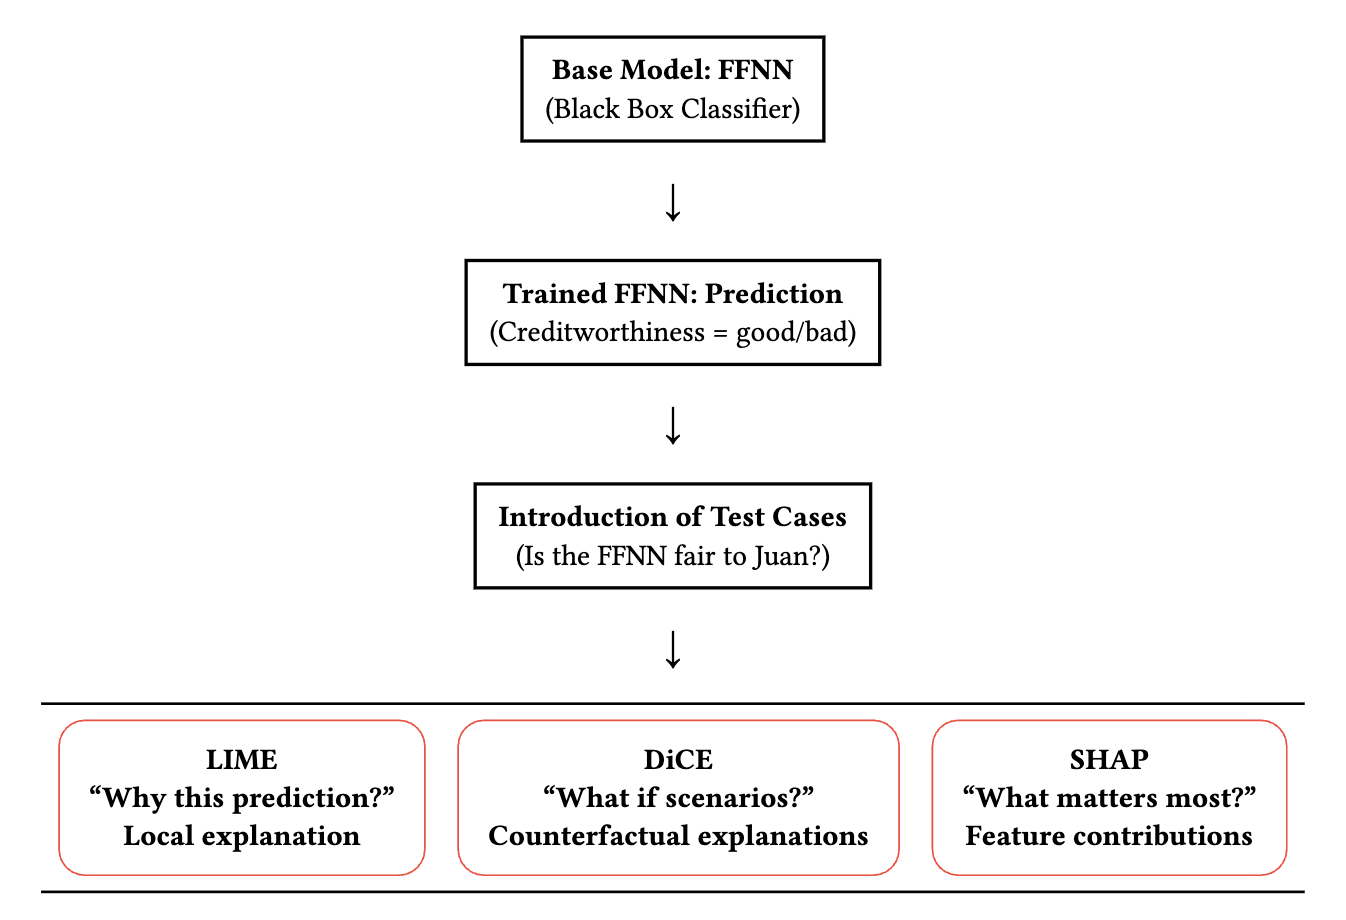

Source: Own diagram

<a name="background-and-prereqs"></a>
# Background & Prerequisites

This notebooks expects a general understanding of machine-learning, in particular neural networks. Furthermore, it expects a good command of Python in order for readers to understand the code blocks that implement the modeling and explanability methods.

## Reading materials

Find reading materials, as well as links to relevant Documentation, at the [end](#references) of this notebook.


<a name="software-requirements"></a>
# Software Requirements

This notebook requires a working installation of the following software:

- Python version >=3.10
- Jupyter
- pip3

Ideally, you run this in Google Colab, as some operations require significant computational power. It will also simplify dependency-management and is tested by us.

The following code cell will install the necessary Python libraries.

In [40]:
!pip install -q pandas numpy matplotlib scikit-learn torch seaborn ucimlrepo lime dice-ml shap lime # pip install using quiet flag

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import lime
from lime.lime_tabular import LimeTabularExplainer
import dice_ml
from dice_ml import Dice
import shap
import random
import warnings

In [42]:
SEED = 123  # set for reproducibility

np.random.seed(SEED)
random.seed(SEED)

# Dataset: German Credit Data
<a name="dataset"></a>

As the topic of this notebook is not a modeling or data transformation exercise, we opt for a well-established dataset specific for machine-learning classification tasks. The data comes already cleaned and needs only minimal preprocessing, which lets us focus this tutorial on the explanability methods, rather than tedious preprocessing and modeling.

Find the dataset here: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


## Data Download

In [43]:
# Fallback; use this in case ucimlrepo is down; further adjustments necessary (column renaming)

import io
import zipfile
import requests

URL = "https://zenodo.org/records/10785677/files/german_data.zip?download=1"

def download_zip_bytes(url: str) -> io.BytesIO:
    r = requests.get(url, stream=True)
    r.raise_for_status()
    return io.BytesIO(r.content)

def read_first_csv_from_zip(zip_bytes: io.BytesIO) -> pd.DataFrame:
    with zipfile.ZipFile(zip_bytes) as z:
        for name in z.namelist():
            if name.lower().endswith(".csv"):
                with z.open(name) as f:
                    return pd.read_csv(f)
    raise FileNotFoundError("No CSV file found inside the ZIP.")

def download_and_load_csv(url: str = URL) -> pd.DataFrame:
    buf = download_zip_bytes(url)
    return read_first_csv_from_zip(buf)

In [44]:
# Dataset from uci ml repo docs

from ucimlrepo import fetch_ucirepo

used_fallback = False

try:
  # fetch dataset
  statlog_german_credit_data = fetch_ucirepo(id=144)

  # data (as pandas dataframes); for model
  X = statlog_german_credit_data.data.features
  y = statlog_german_credit_data.data.targets

  df = pd.concat([X, y], axis=1) # only for EDA use

except ConnectionError as error:
  print(f"{error}! Using fallback dataset.")

  df = download_and_load_csv()
  used_fallback = True

  df = df.rename(columns={'default':'target'})
  y = df[['target']]
  X = df.drop(columns=['target'], inplace=False)

### Features

| Variable Name | Type        |  Description                                          | Units  | Missing Values |
|---------------|-----------|-----------------------------------------------------|-------|----------------|
| Attribute1    | Categorical | Status of existing checking account                 |       | no             |
| Attribute2    | Integer     | Duration                                             | months | no             |
| Attribute3    | Categorical | Credit history                                      |       | no             |
| Attribute4    | Categorical | Purpose                                             |       | no             |
| Attribute5    | Integer     | Credit amount                                       |       | no             |
| Attribute6    | Categorical | Savings account/bonds                               |       | no             |
| Attribute7    | Categorical | Present employment since                             |       | no             |
| Attribute8    | Integer     | Installment rate in percentage of disposable income |       | no             |
| Attribute9    | Categorical | Personal status and sex                           |       | no             |
| Attribute10   | Categorical | Other debtors / guarantors                           |       | no             |
| Attribute11   | Integer     | Present residence since                              |       | no             |
| Attribute12   | Categorical | Property                                            |       | no             |
| Attribute13   | Integer     | Age                                                 | years  | no             |
| Attribute14   | Categorical | Other installment plans                              |       | no             |
| Attribute15   | Categorical | Housing                                             |       | no             |
| Attribute16   | Integer     | Number of existing credits at this bank             |       | no             |
| Attribute17   | Categorical | Job                                                 |       | no             |
| Attribute18   | Integer     | Number of people being liable to provide maintenance for |   | no             |
| Attribute19   | Binary      | Telephone                                          |       | no             |
| Attribute20   | Binary      | foreign worker                                     |       | no             |

More information about each features' categories, definitions and value-mappings can be found [here](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

## Preprocessing

### Renaming

For the purpose of clarity, we will provide meaningful names to the features below.

In [45]:
if not used_fallback:

  X = X.rename(columns={
      "Attribute1": "checking_acct",
      "Attribute2": "duration_months",
      "Attribute3": "credit_history",
      "Attribute4": "purpose",
      "Attribute5": "credit_amount",
      "Attribute6": "savings_acct",
      "Attribute7": "employment_since",
      "Attribute8": "installment_rate",
      "Attribute9": "personal_status_sex",
      "Attribute10": "debtors",
      "Attribute11": "residence_since",
      "Attribute12": "property",
      "Attribute13": "age",
      "Attribute14": "installment_plans",
      "Attribute15": "housing",
      "Attribute16": "existing_credits",
      "Attribute17": "employment",
      "Attribute18": "maintenance_people",
      "Attribute19": "telephone",
      "Attribute20": "foreign_worker"
  })

  y = y.rename(columns={
      "class": "target" # 1 being good, 2 being bad
  })

### One-Hot-Encoding

We need to One-Hot-Encode non-ordinal numerical category columns.

In [46]:
if not used_fallback:
  y["target"] = y["target"].replace({1: 0, 2: 1}).astype(float) # recode target 2 -> 1, 1 -> 0

In [47]:
X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe = X_ohe.astype(float) # convert to numerical values for torch-compatability
X_ohe.head()

,duration_months,credit_amount,installment_rate,residence_since,age,existing_credits,maintenance_people,checking_acct_A12,checking_acct_A13,checking_acct_A14,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,employment_A172,employment_A173,employment_A174,telephone_A192,foreign_worker_A202
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Data splitting & Scaling

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/Test split
X_train_ohe_df, X_test_ohe_df, y_train_df, y_test_df = train_test_split(
    X_ohe, y, test_size=0.2, random_state=SEED
)

# Initialize and fit scaler on the training OHE features, then transform both train and test sets
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train_ohe_df)
X_test_scaled_np = scaler.transform(X_test_ohe_df)

# Store column names for later use
feature_cols = X_ohe.columns.tolist()

X_train = X_train_scaled_np
X_test = X_test_scaled_np

y_train = y_train_df
y_test = y_test_df

In [49]:
# Check for equal size
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

800 800
200 200


## Exploratory Data Analyis

In [50]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [51]:
X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   duration_months          1000 non-null   float64
 1   credit_amount            1000 non-null   float64
 2   installment_rate         1000 non-null   float64
 3   residence_since          1000 non-null   float64
 4   age                      1000 non-null   float64
 5   existing_credits         1000 non-null   float64
 6   maintenance_people       1000 non-null   float64
 7   checking_acct_A12        1000 non-null   float64
 8   checking_acct_A13        1000 non-null   float64
 9   checking_acct_A14        1000 non-null   float64
 10  credit_history_A31       1000 non-null   float64
 11  credit_history_A32       1000 non-null   float64
 12  credit_history_A33       1000 non-null   float64
 13  credit_history_A34       1000 non-null   float64
 14  purpose_A41              

**Key dataset characteristics:**

- 1000 rows
- 20 features (some numerical, some categorical)
  - 48 with categorical features one-hot-encoded
- 1 target: "default" (0 = loan repaid, 1 = loan defaulted)
- No missing values

### Distribution

#### Features

The **Exploratory Data Analysis** is an important step for both model development and interpretability. We need to understand the dataset's characteristics, especially class imbalances and feature distributions, to anticipate how our neural network will learn and how the methods to be implemented will function.

The below code will generate a distribution plot per feature. If you want to understand what each value on the x axis of the plot means (if it is not numerical), please refer to the dataset [documentation](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) .

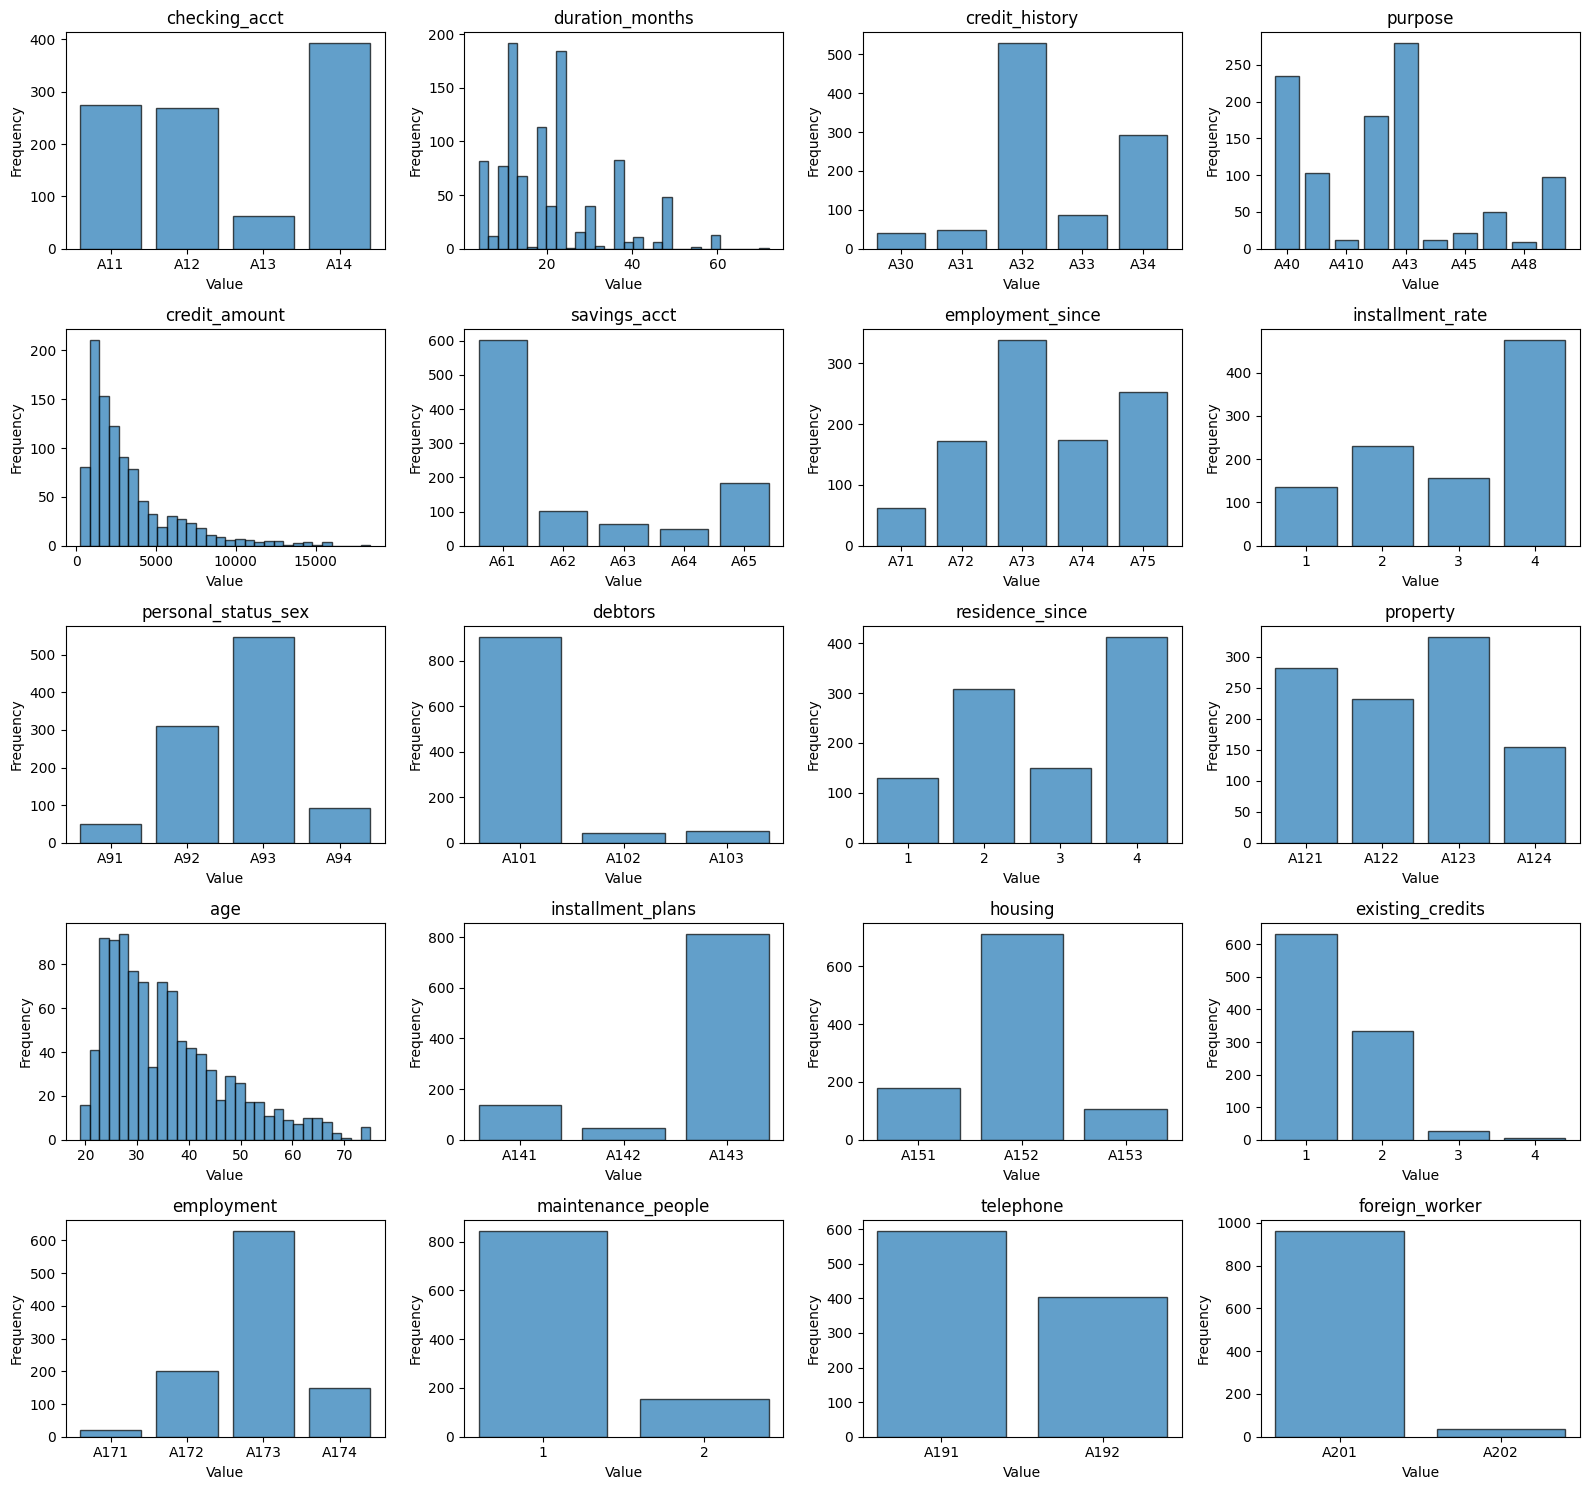

In [52]:
from matplotlib.ticker import MaxNLocator

num_features = X.shape[1]
ncols = 4
nrows = int(np.ceil(num_features / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    ax = axes[idx]
    # Check if column is categorical (object or bool)
    if X[col].dtype == 'object' or X[col].dtype == 'bool' or X[col].nunique() < 20:
        counts = X[col].value_counts().sort_index()
        ax.bar(counts.index.astype(str), counts.values, edgecolor='black', alpha=0.7)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax.hist(X[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Remove unused axes
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


With this dataset, we see some unbalanced categorical features, such as **debtors**, **foreign_worker**, **housing**, to highlight a few. The fact that they are unbalanced requires careful consideration. For example, neural networks, trained with gradient descent, run at risk of representing sparse features less prominently. While this can be a natural property of the data that we are trying to model — e.g., there are just very few instances in the population that are foreign workers — it can also lead to discrimination, as the model might be less certain about foreign workers or simply predict based on the majority class.

#### Target

We want to explicitly check if the target variable is balanced, since class imbalance can  bias the model toward predicting the majority class (e.g., no default). If the classes are imbalanced, we will need to adjust the loss function and using class weights.

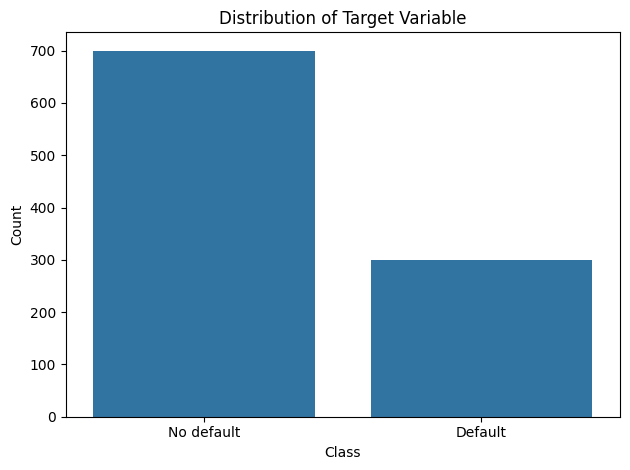

In [53]:
target_counts = y['target'].value_counts().sort_index()

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No default', 'Default'])
plt.tight_layout()
plt.show()

We see that the target is imbalanced, with the majority (70%) of applicants being labeled "no default" and a minority (30%) labeled "default". If we train our neural network like this, the majority class is likely to dominate.

*`BCEWithLogitsLoss`* in [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) can help us have more balanced predictions. The example states that in a dataset containing 100 positive and 300 negative examples of a single class, the positive weight of the class is equal to...

$$
\text{pos\_weight} = \frac{\text{num\_negative}}{\text{num\_positive}}
\;\Rightarrow\;
\text{pos\_weight} = \frac{300}{100}
\;\Rightarrow\;
\text{pos\_weight} = 3
$$

In our case:

$$
\text{pos\_weight} = \frac{700}{300}
\;\Rightarrow\;
\text{pos\_weight} \approx 2.33
$$

This means that every defaulted case in our model will be weighted (2.33x more), so that the learning process does not always predict the majority class. For a more in-depth explanation of the loss function, please refer to  *`pos_weight`*  documentation linked above.

### Feature correlations

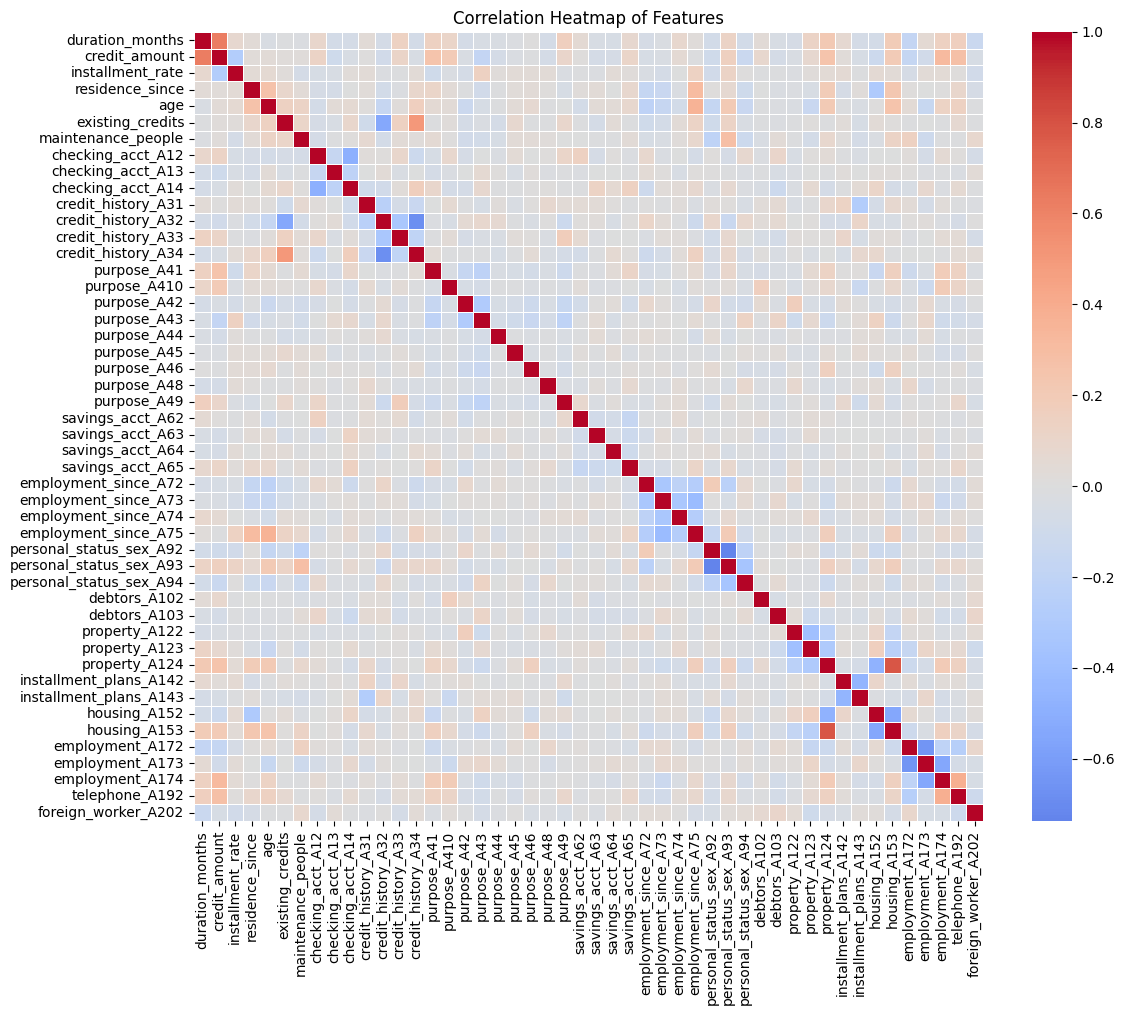

In [54]:
correlation_matrix = X_ohe.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

**The top 10 most correlated features**

In [55]:
corr_pairs = correlation_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # remove self-correlation
corr_pairs = corr_pairs.sort_values(ascending=False)

corr_pairs = corr_pairs.drop_duplicates()

corr_pairs.head(10)

,,0
housing_A153,property_A124,0.779853
personal_status_sex_A93,personal_status_sex_A92,0.738036
credit_history_A32,credit_history_A34,0.683617
employment_A173,employment_A172,0.652438
duration_months,credit_amount,0.624984
housing_A153,housing_A152,0.548445
employment_A173,employment_A174,0.543852
credit_history_A32,existing_credits,0.540354
existing_credits,credit_history_A34,0.501364
checking_acct_A12,checking_acct_A14,0.489136


**Strong positive correlations**

*   `Credit Amount` and `Duration Months`: This is the strongest relationship in the dataset; one hypothesis being larger loans naturally require longer repayment periods
*   `Credit Amount` and `Installment Rate`: Shows a mild-to-moderate positive correlation, might indicate higher credit amounts are generally associated with slightly higher installment burdens

**Moderate positive correlation**
*   `Age` and `Residence Since`: A moderate positive correlation, suggesting older individuals tend to remain longer at their current residence

Other slighly weak correlations
*   `Age` and `Existing Credits`: A weak positive correlation, consistent with the idea that credit accounts accumulate over time
*   `Maintenance People`: Displays very weak correlations with financial variables, indicating household size is largely independent of credit characteristics

Beyond the numeric relationships above, several categorical one-hot pairs also show positive correlations, including housing_A153 and property_A124, personal_status_sex_A93 and A92, credit_history_A32 and A34, and employment_A173 and A172. Most categorical one-hot features show very weak correlations with numeric features, indicating that attributes such as purpose, checking_acct, employment, and savings do not form strong linear relationships with credit_amount, age, or duration_months. However there few correlations such as certain purpose or checking_acct categories show mild association with credit_amount, but none are strong enough to represent meaningful linear patterns.

<a name="modeling"></a>
# Modeling: Neural Network

For this part, we train a base feed-forward neural network (FFNN) for our prediction of default risk. Commonly, banks and credit scoring agencies rely on evaluations of default risk to assess whether an applicant's loan should be approved ("creditworthiness").

Neural networks are black box models, which lack transparency in how scores are calculated. We are choosing this type of model because it is a good baseline, very generalized for many use-cases and compatible with the explainable AI methods we will use (e.g., LIME, DiCE, SHAP).

Our model architecture has the following structure:

*   **Input**: 20 features before processing
*   **Hidden layer 1**: (H1): 128 neurons (ReLU activation)  
*   **Hidden layer 2**: 64 neurons (ReLU activation)  
*   **Hidden layer 3**: 32 neurons (ReLU activation)  
*   **Output**: 1 neuron (logit for Sigmoid activation) to assign good/bad creditability

In [56]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

#The base FFNN
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(), #h1 activation
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(), #h2 activation
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(), #h3 activation
            nn.Dropout(0.2),

            nn.Linear(32, 1) #logit
        )

    def forward(self, x):
        return self.net(x)

In [57]:
# We convert the dataframes to tensors to be able to train with PyTorch
X_train_t = torch.tensor(X_train_scaled_np, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled_np, dtype=torch.float32)

y_train_t = torch.tensor(y_train_df.values, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

#Sanity check of labels
print(y_train_t.unique())
print(y_test_t.unique())

#Sanity check of long
print(y_train_t.dtype)
print(y_test_t.dtype)

tensor([0., 1.])
tensor([0., 1.])
torch.float32
torch.float32


## Traning the FFNN

In [58]:
FFNN_model = MLP(X_train.shape[1])
pos_weight = torch.tensor([700/300]) # this is needed for rebalancing the target
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(FFNN_model.parameters(), lr=1e-3) #standard lr

epochs = 50 # standard value and feasible; sufficient for this exercise

for xb, yb in train_dl:
    print("xb:", xb.shape)  # should be [64, num_features]
    print("yb:", yb.shape)  # should be [64]
    break

for epoch in range(epochs):
  FFNN_model.train()
  epoch_loss = 0

  for xb, yb in train_dl:
    optimizer.zero_grad()

    logits = FFNN_model(xb)
    loss = criterion(logits, yb.squeeze(1)) # Squeeze the target tensor to match the shape of logits

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")

  #Note:  Predictions near the decision threshold are quite sensitive and may vary slightly across model runs, even with set seeds. For underrepresented or group minority cases like Juan's this can change a decision from approval to decline.

xb: torch.Size([64, 48])
yb: torch.Size([64, 1, 1])
Epoch 1 | Loss: 12.5339
Epoch 2 | Loss: 12.2660
Epoch 3 | Loss: 11.7755
Epoch 4 | Loss: 10.8433
Epoch 5 | Loss: 10.0576
Epoch 6 | Loss: 9.2691
Epoch 7 | Loss: 8.5614
Epoch 8 | Loss: 8.4262
Epoch 9 | Loss: 8.1729
Epoch 10 | Loss: 7.7932
Epoch 11 | Loss: 7.4174
Epoch 12 | Loss: 7.1689
Epoch 13 | Loss: 6.7272
Epoch 14 | Loss: 6.3823
Epoch 15 | Loss: 6.2022
Epoch 16 | Loss: 6.5000
Epoch 17 | Loss: 5.7789
Epoch 18 | Loss: 5.1797
Epoch 19 | Loss: 5.3724
Epoch 20 | Loss: 4.6295
Epoch 21 | Loss: 4.2225
Epoch 22 | Loss: 3.9973
Epoch 23 | Loss: 4.3218
Epoch 24 | Loss: 4.4046
Epoch 25 | Loss: 4.0227
Epoch 26 | Loss: 4.1453
Epoch 27 | Loss: 3.5937
Epoch 28 | Loss: 3.7205
Epoch 29 | Loss: 3.2056
Epoch 30 | Loss: 3.0372
Epoch 31 | Loss: 2.7255
Epoch 32 | Loss: 3.3592
Epoch 33 | Loss: 3.3210
Epoch 34 | Loss: 2.9799
Epoch 35 | Loss: 2.8776
Epoch 36 | Loss: 2.3650
Epoch 37 | Loss: 2.6595
Epoch 38 | Loss: 2.4995
Epoch 39 | Loss: 2.4921
Epoch 40 | Loss:

## Performance

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy Evaluation
FFNN_model.eval()
with torch.no_grad():
    logits = (FFNN_model(X_test_t))
    probs = torch.sigmoid(logits)
    pred = (probs >= 0.5).float()

    pred_np = pred.squeeze(1).cpu().numpy()
    y_test_np = y_test_t.squeeze(1).cpu().numpy()

# ----- FFNN / MLP -----
print("\n Feed-Forward Neural Network Results")
print("--------------------------------------")
print("FFNN Test Accuracy:", accuracy_score(y_test_np, pred_np))
print("\nFFNN Classification Report:\n", classification_report(y_test_np, pred_np))
print("FFNN Confusion Matrix:\n", confusion_matrix(y_test_np, pred_np))


 Feed-Forward Neural Network Results
--------------------------------------
FFNN Test Accuracy: 0.775

FFNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.82      0.84       139
         1.0       0.62      0.67      0.65        61

    accuracy                           0.78       200
   macro avg       0.74      0.75      0.74       200
weighted avg       0.78      0.78      0.78       200

FFNN Confusion Matrix:
 [[114  25]
 [ 20  41]]


After adjusting with class weights, the FFNN registers between 77%-85 test accuracy, based on the random run of the model, and in general is sufficient to continue with a meaningful analysis. We still see some bias toward the majority class of default risk (0 = no default, 82-85% precision) but also a resonable performance for the minority class (1 = default, 60-62% precision).

**Recap.** Until this point, we have done the following things:

✅ Downloaded the data\
✅ Explored the data\
✅ Transformed the data to fit the modeling task\
✅ Trained a simple Neural Network and evaluated its performance

Now we will proceed to the core of this tutorial: The application of explanation methods for our trained model.

<a name="xai-methods"></a>
# xAI Methods

## Taxonomy of Model Interpretability Methods

Model interpretability methods can be characterized with 3 dimensions: scope, model and stage. What does each dimension mean?

![](https://christophm.github.io/interpretable-ml-book/images/taxonomy.jpg)

[Figure source](https://christophm.github.io/interpretable-ml-book/overview.html)

**By-design vs. post-hoc**
Interpretability can either be integrated in the model architecture from the start, or be applied post-hoc. Interpretability by design means that we train inherently interpretable models, such as using logistic regression. Post-hoc methods can be applied after training to a variety of different model architectures. We focus on post-hoc methods.

**Model-agnostic vs. model-specific**\
Methods can be designed to work with very specific model architectures (model-specific), or more general, to work with various different methods (model-agnostic). We opt for model-agnostic methods to provide as much general applicability and therefore value for the reader, as possible.

**Scope**\
A method is either global or local, meaning, it can either yield information about *general (global) model tendencies*, or explain *individual predictions*.

[Read more](https://christophm.github.io/interpretable-ml-book/overview.html)

## Toy Example

**Meet Juan, a 35-year-old immigrant living in Germany.**

Juan runs a small bookstore in Pankow, Berlin. Recently, a flooding from an adjacent building damaged his shop, so urgently applied for a loan to repair the property and keep the store running.

On paper, Juan looks like a strong applicant: he has stable self-employment and residence, has repaid previous credits on time and has no missed payments, some of the most important features that should classify him as good, concluding from out exploratory data anaylsis.

However, a few days later, his loan application is rejected. Confused and frustrated, Juan wants to understand *why* and files a complaint to know more. *"I've always paid my loans back and on time, what is going on?"*

This is where our team comes in. Can AI methods such as LIME, SHAP, and DiCE tell us where the model failed Juan?

In [60]:
#Juan credit attributes

credit_amount = 3000

juan_dict = {
    'duration_months': 14,
    'credit_amount': credit_amount,
    'installment_rate': 2,
    'residence_since': 4,
    'age': 35,
    'existing_credits': 2,
    'maintenance_people': 1,
    'checking_acct_A12': 1,
    'checking_acct_A13': 0,
    'checking_acct_A14': 0,
    'credit_history_A31': 0,
    'credit_history_A32': 1,
    'credit_history_A33': 0,
    'credit_history_A34': 0,
    'purpose_A41': 0,
    'purpose_A410': 0,
    'purpose_A42': 0,
    'purpose_A43': 0,
    'purpose_A44': 0,
    'purpose_A45': 1,
    'purpose_A46': 0,
    'purpose_A48': 0,
    'purpose_A49': 0,
    'savings_acct_A62': 1,
    'savings_acct_A63': 0,
    'savings_acct_A64': 0,
    'savings_acct_A65': 0,
    'employment_since_A72': 0,
    'employment_since_A73': 1,
    'employment_since_A74': 0,
    'employment_since_A75': 0,
    'personal_status_sex_A92': 0,
    'personal_status_sex_A93': 1,
    'personal_status_sex_A94': 0,
    'debtors_A102': 0,
    'debtors_A103': 0,
    'property_A122': 0,
    'property_A123': 0,
    'property_A124': 1,
    'installment_plans_A142': 1,
    'installment_plans_A143': 0,
    'housing_A152': 1,
    'housing_A153': 0,
    'employment_A172': 0,
    'employment_A173': 0,
    'employment_A174': 1,
    'telephone_A192': 1,
    'foreign_worker_A202': 1
}

juan = pd.DataFrame([juan_dict])
juan

,duration_months,credit_amount,installment_rate,residence_since,age,existing_credits,maintenance_people,checking_acct_A12,checking_acct_A13,checking_acct_A14,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,employment_A172,employment_A173,employment_A174,telephone_A192,foreign_worker_A202
0,14,3000,2,4,35,2,1,1,0,0,...,1,1,0,1,0,0,0,1,1,1


**Let's compare this case with Maximilian, is a 67-year-old single male living in Germany.**

Maximilian is a skilled worker with stable employment for the past 7 years, living in rented accomodation.

He is applying for a short-term loan worth €1,000.00 for a television. Similar to Juan, Maximilian has a good credit history with 2 existing credits and no other installment plans. While he has modest savings, his request is far below the average loan and is exactly the kind of reliable borrower that should be approved. His application is accepted.


In [61]:
#Maximilian credit attributes

maximilian_dict = {
    'duration_months': 6,
    'credit_amount': 1000,
    'installment_rate': 4,
    'residence_since': 4,
    'age': 67,
    'existing_credits': 2,
    'maintenance_people': 1,
    'checking_acct_A12': 0,
    'checking_acct_A13': 1,  # Improved: >= 0 DM
    'checking_acct_A14': 0,
    'credit_history_A31': 0,
    'credit_history_A32': 0,
    'credit_history_A33': 0,
    'credit_history_A34': 1,
    'purpose_A41': 0,
    'purpose_A410': 0,
    'purpose_A42': 0,
    'purpose_A43': 1,
    'purpose_A44': 0,
    'purpose_A45': 0,
    'purpose_A46': 0,
    'purpose_A48': 0,
    'purpose_A49': 0,
    'savings_acct_A62': 0,
    'savings_acct_A63': 0,
    'savings_acct_A64': 0,
    'savings_acct_A65': 1,
    'employment_since_A72': 0,
    'employment_since_A73': 0,
    'employment_since_A74': 0,
    'employment_since_A75': 1,
    'personal_status_sex_A92': 0,
    'personal_status_sex_A93': 1,
    'personal_status_sex_A94': 0,
    'debtors_A102': 0,
    'debtors_A103': 0,
    'property_A122': 1,  # Has building society savings agreement/life insurance
    'property_A123': 0,
    'property_A124': 0,
    'installment_plans_A142': 0,
    'installment_plans_A143': 1,
    'housing_A152': 1,
    'housing_A153': 0,
    'employment_A172': 0,
    'employment_A173': 0,
    'employment_A174': 1,  # Highly qualified/self-employed/management
    'telephone_A192': 1,
    'foreign_worker_A202': 0
}

max = pd.DataFrame([maximilian_dict])
max

,duration_months,credit_amount,installment_rate,residence_since,age,existing_credits,maintenance_people,checking_acct_A12,checking_acct_A13,checking_acct_A14,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,employment_A172,employment_A173,employment_A174,telephone_A192,foreign_worker_A202
0,6,1000,4,4,67,2,1,0,1,0,...,0,0,1,1,0,0,0,1,1,0


If we ask our model for a prediction on Juan and Maximilian's data, we get the following results:

In [62]:
class_names = ["approve", "decline"]

def make_prediction(name: str, data_df: pd.DataFrame, threshold: float = 0.5):
    FFNN_model.eval()

    data_scaled_np = scaler.transform(data_df)
    data_t = torch.tensor(data_scaled_np, dtype=torch.float32)

    with torch.no_grad():
        logit = FFNN_model(data_t).item()            # Get logit as scalar
        prob_decline = torch.sigmoid(torch.tensor(logit)).item()  # P(decline)
        pred = (prob_decline >= threshold)           # boolean for class

    print(f"{name}'s predicted class: {class_names[int(pred)]}")
    print(f"  Logit = {logit:.3f}")

for i in [["Juan", juan], ["Maximilian", max]]:
    print(f"---- {i[0]}'s prediction ----")
    make_prediction(i[0], i[1])
    print()

---- Juan's prediction ----
Juan's predicted class: decline
  Logit = 2.936

---- Maximilian's prediction ----
Maximilian's predicted class: approve
  Logit = -11.436



If we based our creditworthiness decisions exclusively on the untreated dataset of applicants, we would promote systemic bias. It is likely other cases like Juan's exist, where the underlying reasons for decline remain opaque. For example, a different probability threshold (e.g. 0.50 vs. a low/higher one) could flip decisions. Additionally, predictions could be tied to specific features that require bias checks.

## Local Interpretable Model-agnostic Explanations (LIME)

**Local | Agnostic | Post-hoc**

LIME is a technique designed to shed light on "black box" models by explaining individual predictions in a way that humans can understand. It explains a single prediction of by approximating it locally with a simple, interpretable model. It doesn't try to explain the entire model's behavior. Instead, it focuses on explaining *one specific prediction* at a time. For example, if a model predicts that a customer is "high risk" of credit default, LIME will tell you *why that particular customer* was classified that way. This is a powerful tool and can be used with *any* machine learning model (e.g., Random Forests, Support Vector Machines, Neural Networks).

### How does LIME work? (Intuition)

To explain a specific outcome LIME creates many slightly modified versions (perturbations) of the original data point. For tabular data, this might involve slightly changing feature values or reversing one-hot-encoded features. It feeds these perturbed data points to the model and gets predictions for each of them. It then weighs these perturbed samples based on how close they are to the *original* data point one is trying to explain. Samples very similar to the original get a higher weight. Finally, it trains a simple, *interpretable* model (like a linear regression or decision tree) on these weighted, perturbed samples and their predictions. This simple model is trained to explain the complex model's behavior *only in the vicinity* of the original data point.

### Why LIME is useful for this project

LIME is model-agnostic and it's perfect for fit our case study, as we want individual-level explanations for Juan's and Maximilian's cases.

In [63]:
# LIME wrapper and explainer

# feature names: same order as the model input
feature_names = list(feature_cols)
print("Number of features:", len(feature_names))

# class names from your existing code
print("Class names:", class_names)

def predict_proba_lime(X_scaled_array: np.ndarray) -> np.ndarray:
    """
    Input: numpy array of shape (n_samples, n_features) – already SCALED
    Output: numpy array of shape (n_samples, 2) with [P(approve), P(decline)]
    """
    FFNN_model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_scaled_array, dtype=torch.float32)
        logits = FFNN_model(X_t)                 # (n_samples, 1) logit for "decline" (class 1)
        p_decline = torch.sigmoid(logits).squeeze(1)    # P(y=1)
        p_approve = 1.0 - p_decline                     # P(y=0)
        probs = torch.stack([p_approve, p_decline], dim=1)
        return probs.cpu().numpy()

# LIME explainer: use the scaled training data as background
explainer = LimeTabularExplainer(
    training_data=X_train_scaled_np,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    random_state=SEED
)

print("LIME explainer ready.")


Number of features: 48
Class names: ['approve', 'decline']
LIME explainer ready.


---- Juan ----
P(approve) = 0.05037957429885864
P(decline) = 0.9496204257011414
Predicted decision: decline

LIME explanation for Juan (feature, weight):
purpose_A41 <= -0.34: 0.1017 (↑ high risk of decline)
checking_acct_A14 <= -0.82: 0.0955 (↑ high risk of decline)
purpose_A48 <= -0.09: 0.0893 (↑ high risk of decline)
foreign_worker_A202 > -0.20: -0.0876 (↓ Low risk of decline)
checking_acct_A13 <= -0.27: 0.0868 (↑ high risk of decline)
credit_history_A33 <= -0.31: 0.0860 (↑ high risk of decline)
savings_acct_A64 <= -0.23: 0.0849 (↑ high risk of decline)
purpose_A410 <= -0.11: 0.0792 (↑ high risk of decline)
credit_history_A34 <= -0.64: 0.0733 (↑ high risk of decline)
property_A124 > -0.43: 0.0715 (↑ high risk of decline)
purpose_A44 <= -0.12: 0.0630 (↑ high risk of decline)
debtors_A102 <= -0.20: -0.0589 (↓ Low risk of decline)
purpose_A49 <= -0.34: 0.0587 (↑ high risk of decline)
purpose_A45 > -0.16: -0.0581 (↓ Low risk of decline)
employment_since_A74 <= -0.46: 0.0488 (↑ high risk

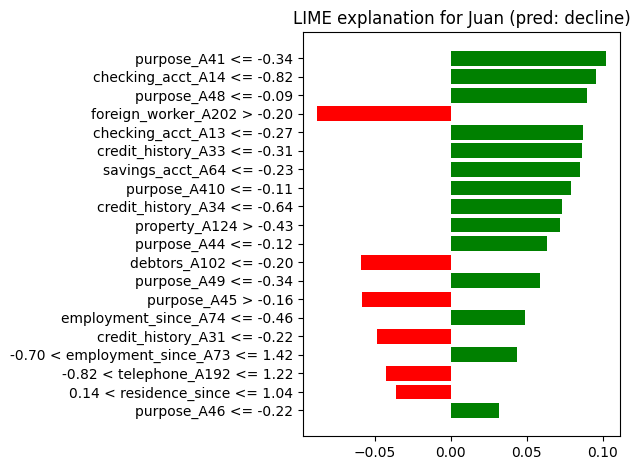


Local fidelity for Juan (R² of surrogate): 0.1854


In [64]:
# LIME explanation for Juan

# 1) Scale Juan using the same scaler as the training data
juan_scaled = scaler.transform(juan[feature_cols])
juan_scaled_row = juan_scaled[0]  # 1D array

# 2) Model prediction for Juan
probs_juan = predict_proba_lime(juan_scaled)[0]  # [P(approve), P(decline)]
p_approve_juan, p_decline_juan = float(probs_juan[0]), float(probs_juan[1])
pred_class_idx_juan = int(np.argmax(probs_juan))
pred_class_name_juan = class_names[pred_class_idx_juan]

print("---- Juan ----")
print("P(approve) =", p_approve_juan)
print("P(decline) =", p_decline_juan)
print("Predicted decision:", pred_class_name_juan)

# 3) LIME explanation for Juan
exp_juan = explainer.explain_instance(
    data_row=juan_scaled_row,
    predict_fn=predict_proba_lime,
    num_features=20,
    top_labels=1

)

print("\nLIME explanation for Juan (feature, weight):")
for feature, weight in exp_juan.as_list(label=pred_class_idx_juan):
    direction = "↑ high risk of decline" if (pred_class_idx_juan == 1 and weight > 0) or (pred_class_idx_juan == 0 and weight < 0) else "↓ Low risk of decline"
    print(f"{feature}: {weight:.4f} ({direction})")

# 4) Plot
fig = exp_juan.as_pyplot_figure(label=pred_class_idx_juan)
plt.title(f"LIME explanation for Juan (pred: {pred_class_name_juan})")
plt.tight_layout()
plt.show()

print(f"\nLocal fidelity for Juan (R² of surrogate): {exp_juan.score:.4f}")

### How to read: Bar Graph of Feature Contributions

The graph above visualizes the local feature contributions to the model's prediction. These graphs will look differently for each applicant, since they're explaining individual predictions based on an applicant's specific feature values. In our case, the features that matter most for Juan's "decline" are not the same as those that matter for Maximilian's "approval".

*   **Green bars** indicate features that positively increase the outcome of a prediction, e.g. P(decline).
*   **Red bars** negatively influence or decrease the likelihood of the same prediction.

### Interpretation

**Juan's case:** The model's decision to decline Juan is mostly driven by *purpose_A41 <= -0.34* which is the strongest contributor (Juan not pruchasing a used car). The status of his *checking_account_A14* is also another contributor along with *purpose_A48* (retraining), both set to 0. These features, combined with others (e.g. *checking_acct_A13*, *credit_history_A33**, *savings_acct_A64*, *purpose_A410*, and *credit_history_A34*) are collectively interpreted as unfavorable aspects of Juan's financial profile.

Suprisingly, being a *foreign_worker_A202 > -0.20* is not a major contributor to Juan's loan denial. Actually, it is the most prominent red bar and *reduces* the likelihood of his loan being declined, meaning it pushes towards approval. This is relevant finding given concerns about biases against foreign workers. Other features, such as *debtors_A102*, having no debtors as co-applicants, or *purpose_A45* (repair related  purpose), are also working in his favor.

In summary, Juan's decline was strongly driven by his purpose, loan amount, duration, and several aspects of his credit history aspects (for instance, he has two loans). The positive aspects include him being a foreign worker, having no debtors, and requesting the loan for a repair-related purpose, but these are not outweighted by those other features pushing toward decline.

---- Maximilian ----
P(approve) = 0.9999892115592957
P(decline) = 1.0799469237099402e-05
Predicted decision: approve

LIME explanation for Maximilian (feature, weight):
checking_acct_A14 <= -0.82: -0.1104 (↑ high risk of decline)
purpose_A41 <= -0.34: -0.1025 (↑ high risk of decline)
purpose_A410 <= -0.11: -0.0985 (↑ high risk of decline)
purpose_A48 <= -0.09: -0.0951 (↑ high risk of decline)
checking_acct_A13 > -0.27: 0.0905 (↓ low risk of decline)
debtors_A102 <= -0.20: 0.0899 (↓ low risk of decline)
foreign_worker_A202 <= -0.20: -0.0889 (↑ high risk of decline)
credit_history_A33 <= -0.31: -0.0835 (↑ high risk of decline)
savings_acct_A64 <= -0.23: -0.0797 (↑ high risk of decline)
-0.64 < credit_history_A34 <= 1.56: 0.0705 (↓ low risk of decline)
purpose_A45 <= -0.16: -0.0703 (↑ high risk of decline)
purpose_A49 <= -0.34: -0.0623 (↑ high risk of decline)
purpose_A44 <= -0.12: -0.0606 (↑ high risk of decline)
purpose_A46 <= -0.22: -0.0599 (↑ high risk of decline)
property_A124 <= -0.

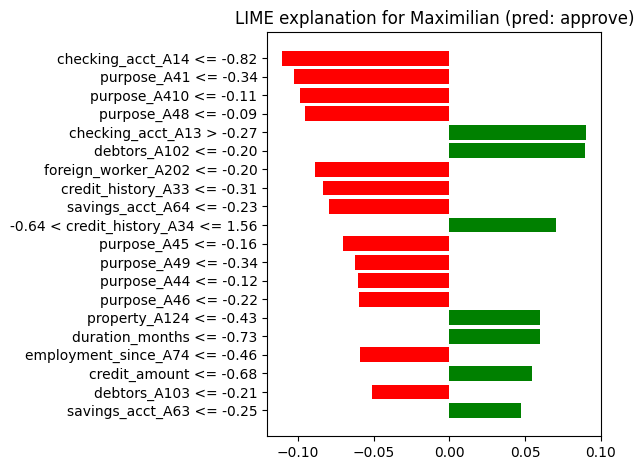


Local fidelity for Maximilian (R² of surrogate): 0.1944


In [65]:
# LIME explanation for Maximilian

max_scaled = scaler.transform(max[feature_cols])
max_scaled_row = max_scaled[0]

probs_max = predict_proba_lime(max_scaled)[0]
p_approve_max, p_decline_max = float(probs_max[0]), float(probs_max[1])
pred_class_idx_max = int(np.argmax(probs_max))
pred_class_name_max = class_names[pred_class_idx_max]

print("---- Maximilian ----")
print("P(approve) =", p_approve_max)
print("P(decline) =", p_decline_max)
print("Predicted decision:", pred_class_name_max)

exp_max = explainer.explain_instance(
    data_row=max_scaled_row,
    predict_fn=predict_proba_lime,
    num_features=20,
    top_labels=1
)

print("\nLIME explanation for Maximilian (feature, weight):")
for feature, weight in exp_max.as_list(label=pred_class_idx_max):
    direction = "↑ high risk of decline" if (pred_class_idx_max == 1 and weight > 0) or (pred_class_idx_max == 0 and weight < 0) else "↓ low risk of decline"
    print(f"{feature}: {weight:.4f} ({direction})")

fig = exp_max.as_pyplot_figure(label=pred_class_idx_max)
plt.title(f"LIME explanation for Maximilian (pred: {pred_class_name_max})")
plt.tight_layout()
plt.show()

print(f"\nLocal fidelity for Maximilian (R² of surrogate): {exp_max.score:.4f}")

**Maximilian's case:** The strongest contributor to Maximilian's approval is *checking_acct_A13* (having a balance between 0-200 DM). Along with *debtors_A102*, or the absence of other debtors/guarantor, this is the strongest positive contributor. The latter one is similar to Juan's case. Overall, Maximilian's individual profile suggests that his credit history, credit amount (<€1000) and a shorter loan term duration positively contributed to his approval.

Among the categories going against this approval, we can find *checking_acct_A14* (≥200 DM), *purpose_A41* (used car),*purpose_A410* (new car) and *purpose_A48* (retraining), meaning the model considers negative responses to these as a negative aspect in his applicant profile, which is not so thoroughly explained. Being a non-foreign worker in this context appears to have a negative impact on Maximilian's approval, which is an interesting contrast to Juan's case and warrants further investigation.

In summary, Maximilian's approval was strongly driven by his checking account status, clear credit history, and the conservative nature of his loan request (low amount, short duration). The negative influences were primarily related to specific loan purposes and the lack of a very high-balance checking account, both of which are outweighted by the other features.

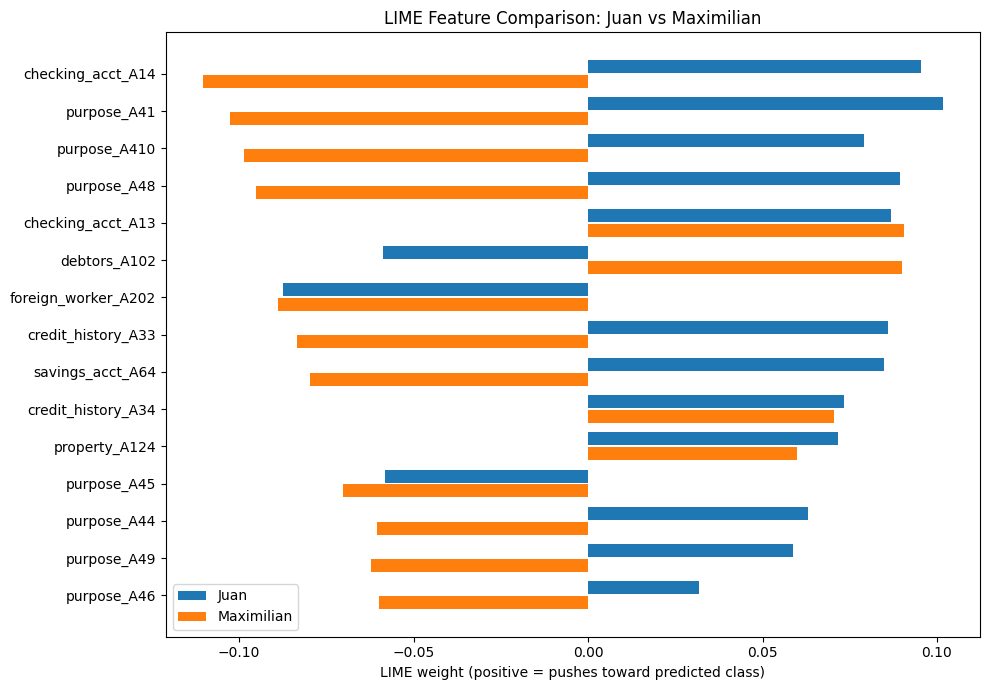

,Juan,Maximilian
checking_acct_A14,0.095491,-0.110374
purpose_A41,0.101731,-0.102548
purpose_A410,0.079151,-0.098490
purpose_A48,0.089267,-0.095144
checking_acct_A13,0.086802,0.090481
debtors_A102,-0.058895,0.089885
foreign_worker_A202,-0.087568,-0.088903
credit_history_A33,0.085982,-0.083514
savings_acct_A64,0.084908,-0.079694
credit_history_A34,0.073299,0.070477


In [66]:
# === Compare Juan vs Maximilian in a single chart ===

def exp_to_series(exp, label_idx, name):
    items = exp.local_exp[label_idx]  # (feature_idx, weight)
    return pd.Series({feature_names[i]: w for i, w in items}, name=name)

juan_series = exp_to_series(exp_juan, pred_class_idx_juan, "Juan")
max_series  = exp_to_series(exp_max,  pred_class_idx_max,  "Maximilian")

df_cmp = pd.concat([juan_series, max_series], axis=1).fillna(0)

# sort by biggest impact
df_cmp["absmax"] = df_cmp.abs().max(axis=1)
df_cmp = df_cmp.sort_values("absmax", ascending=False).head(15)
df_cmp = df_cmp.drop(columns=["absmax"])

plt.figure(figsize=(10, 7))
y = np.arange(len(df_cmp))

plt.barh(y - 0.2, df_cmp["Juan"], height=0.35, label="Juan")
plt.barh(y + 0.2, df_cmp["Maximilian"], height=0.35, label="Maximilian")

plt.yticks(y, df_cmp.index)
plt.title("LIME Feature Comparison: Juan vs Maximilian")
plt.xlabel("LIME weight (positive = pushes toward predicted class)")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

df_cmp

### How to read: Combined Feature Comparison Graph

The LIME Feature Comparison bar graphs contrast explanations for Juan (blue bars) and Maximilian (orange bars). Each bar represents the 'LIME weight' or contribution of a specific feature to the individual's prediction.

- **X-axis (LIME weight)** shows the strength and direction of a feature on the model's prediction for that specific individual
- **Y-axis (Features)** lists the top features that had the most impact on either Juan or Maximilian's prediction, sorted by overall impact

Features on the right of zero (positive LIME weights) mean the model is being pushed toward the outcome (decline for Juan, approve for Maximilian), while features on the left (negative LIME weights) push the prediction away from that outcome.

### Conclusion (LIME)

LIME provides local explanations for individual predictions, highlighting features that influenced the model's decision for a specific instance. In the case of Juan, his loan was declined for economic and behavioral reasons: his loan purpose, amount and duration, checking account status, and aspects of credit history pushed the model toward decline. In the case of Maximilian, this is driven by lower financial risk, since the requested amount and duration of the loan is lower, and he has a strong credit history.

Both decisions could be interpreted by conventional credit risk criteria, although the behavior of some features still need further explanation. For example *foreign_worker_A202* reduced the likelihood of decline for Juan, whereas in Maximilian's case, it reduced the likelihood of approval. While we may be inclined to rule out the simple bias assumption (e.g., "being a foreigner is negative for the loan decision"), this raises questions about whether the classifications of the black box model are context dependent or rely on feature interactions in ways that are not immediately visible from local explanations.

## What-If: Counterfactual Analysis

**Local | Agnostic | Post-hoc**

### Diverse Counterfactual Explanations (DiCE) Overview

What-if (counterfactual) analysis is a method that examines how changes to input features would alter a model's outcome. This analysis answers questions such as “What minimal change to the input would have resulted in a different decision?”. Unlike feature-attribution methods that justify a model's current output, counterfactual analysis focuses on alternative scenarios, typically searching for minimally different, plausible data points that lead to different predictions. This makes it a powerful tool for interpreting black-box models, improving trust, and enabling transparency in automated decision-making systems.

### What are we trying to do here
We use the "dice-ml" library to perform a "what-if" counterfactual analysis on our model. DiCE shows feature-perturbed versions of applicants, in this case Juan and Maximilian, who would have received the loan (e.g., receiving the loan if their income was €5,000 higher"). This provides "what-if" explanations that can complement other methods, both for end-users and model developers. In this case, we seek to understand, "What changes (input features/attributes) would flip Juan or Maximilian's loan decision from Declined to Approved?”

**Note: Counterfactuals do not imply that these findings are causal, or that changes are realistic (example: age) or desirable in real life. They simply reveal clues to how the model makes decisions and potential alternatives.**

![](https://www.microsoft.com/en-us/research/uploads/prod/2020/01/MSR-Amit_1400x788-v3-1blog.gif)

[Figure source](https://interpret.ml/DiCE/)

In [67]:
# for reproducibility
warnings.filterwarnings("ignore")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [68]:
# Wrapper class used in dice-ml so its compatible with Dice/Sklearn API
class PyTorchWrapper:
    def __init__(self, model, feature_names, scaler=None, device=None):
        """
        Wrapper to make PyTorch model compatible with DiCE/sklearn API

        Args:
            model: Trained PyTorch model
            feature_names: List of feature column names in correct order
            scaler: sklearn scaler (StandardScaler, MinMaxScaler, etc.)
            device: torch device ('cuda' or 'cpu'). Auto-detects if None
        """
        self.model = model
        self.feature_names = feature_names
        self.scaler = scaler

        # Auto-detect device
        if device is None:
            self.device = next(model.parameters()).device
        else:
            self.device = torch.device(device)

        self.model.to(self.device)
        self.classes_ = np.array([0, 1])

    def _prepare_input(self, X):
        """Convert input to properly formatted numpy array"""
        if isinstance(X, pd.DataFrame):
            X_df = X.reindex(columns=self.feature_names, fill_value=0)
            X_arr = X_df.values.astype(np.float32)
        elif isinstance(X, pd.Series):
            X_df = X.to_frame().T.reindex(columns=self.feature_names, fill_value=0)
            X_arr = X_df.values.astype(np.float32)
        else:
            X_arr = np.asarray(X, dtype=np.float32)

        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(1, -1)

        return X_arr

    def predict_proba(self, X):
        """Predict class probabilities - required by DiCE"""
        try:
            self.model.eval()
            X_arr = self._prepare_input(X)

            # Apply scaler if it exists
            if self.scaler is not None:
                X_arr = self.scaler.transform(X_arr)

            X_tensor = torch.from_numpy(X_arr).to(self.device)

            with torch.no_grad():
                logits = self.model(X_tensor)
                probs = torch.sigmoid(logits).cpu().numpy()

            if probs.ndim == 1:
                probs = probs.reshape(-1, 1)

            probs = np.clip(probs, 1e-7, 1 - 1e-7)
            return np.hstack([1 - probs, probs])

        except Exception as e:
            print(f"Error in predict_proba: {e}")
            raise

    def predict(self, X):
        """Predict class labels"""
        probs = self.predict_proba(X)
        return (probs[:, 1] > 0.5).astype(int)

    def __repr__(self):
        return f"PyTorchWrapper(model={self.model.__class__.__name__}, features={len(self.feature_names)}, scaler={self.scaler is not None})"


#creating the wrapped model
wrapped_model = PyTorchWrapper(
    model=FFNN_model,
    feature_names=feature_cols,
    scaler=scaler,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(wrapped_model)

PyTorchWrapper(model=MLP, features=48, scaler=True)


In [69]:
# Using DICE model for counterfactual analysis

# Check if y is a pandas Series (or DataFrame)
if not isinstance(y, (pd.Series, pd.DataFrame)):
    y = pd.Series(y, name="target")

# Align indices
X_ohe = X_ohe.reset_index(drop=True)
y = y.reset_index(drop=True)

# Create df_for_dice from one- hot-encoding
df_for_dice = pd.concat([X_ohe, y], axis=1)

class_names = ["approve", "decline"]

# Convert Juan and Max data types to match df_for_dice
df_for_dice_dtypes = df_for_dice.drop('target', axis=1).dtypes

juan_for_dice = juan.copy()
max_for_dice = max.copy()

for col in juan_for_dice.columns:
    if col in df_for_dice_dtypes.index:
        juan_for_dice[col] = juan_for_dice[col].astype(df_for_dice_dtypes[col])
        max_for_dice[col] = max_for_dice[col].astype(df_for_dice_dtypes[col])


# Create DiCE explainer
toy_data = pd.concat([juan_for_dice, max_for_dice], ignore_index=True)
df_for_dice_with_toys = pd.concat([df_for_dice, toy_data], ignore_index=True)

# all feature cols are float64 to avoids pandas dtype warnings in DiCE
feature_cols = [c for c in df_for_dice_with_toys.columns if c != "target"]
df_for_dice_with_toys[feature_cols] = df_for_dice_with_toys[feature_cols].astype("float64")

# separate continuous and categorical (one-hot) columns - to avoid the categorical output from dice into continous values
categorical_features = [
    col for col in df_for_dice_with_toys.columns
    if col != "target" and set(df_for_dice_with_toys[col].unique()) <= {0.0, 1.0}
]

continuous_features = [
    col for col in df_for_dice_with_toys.columns
    if col not in categorical_features and col != "target"
]

d_new = dice_ml.Data(
    dataframe=df_for_dice_with_toys,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

wrapped_model = PyTorchWrapper(
    model=FFNN_model,
    feature_names=feature_cols,
    scaler=scaler  )
dice_model_new = dice_ml.Model(model=wrapped_model, backend='sklearn', model_type='classifier')
exp_new = Dice(d_new, dice_model_new, method='random')


In [70]:
# Counterfactual Analysis


print("\nCounterfactual analysis for Juan")

toy_examples = [
    ("Juan", juan, juan_for_dice),
 #   ("Maximilian", max, max_for_dice)  # Uncomment if needed, only showing for Juan
]


for name, person_df, person_df_with_target in toy_examples:
    print(f"\n{name.upper()}'S LOAN APPLICATION")
    print()

    # predict the loan approval decision for applicant
    make_prediction(name, person_df)

    print(f"\n{name}'s Application Data:")
    print(person_df.to_string())

    # Generate counterfactuals
    print(f"\n\nWhat {name} needs get changed to get his loan approved:")

    try:

        query_df = person_df_with_target.drop('target', axis=1, errors='ignore')

        # Get model's prediction
        current_pred = wrapped_model.predict(query_df)
        person_df_with_target['target'] = float(current_pred[0])

        print(f"Model prediction: {'Declined' if current_pred[0] == 1 else 'Approved'} (class={current_pred[0]})")


        dice_exp = exp_new.generate_counterfactuals(
            query_df,
            total_CFs=3,
            desired_class=0,  # 0 = approve , 1 = decline
            features_to_vary="all",
            #features_to_vary=continous_features,
            permitted_range={
                'age': [18, 75],
                'credit_amount': [250, 20000],
                'duration_months': [4, 72],
                'installment_rate': [1, 4]
            },
            verbose=False,
            random_seed=42
        )

        cf_df = dice_exp.cf_examples_list[0].final_cfs_df


        print(f"\n\nDiCE's Analysis of Changes:")
        cf_list_obj = dice_exp.cf_examples_list[0]

        # full dataframe of counterfactuals
        final_cfs_df = cf_list_obj.final_cfs_df.copy()
        orig_df = cf_list_obj.test_instance_df.reset_index(drop=True).iloc[0]

        # Drop target column
        final_cfs_df = final_cfs_df.drop(columns=['target'], errors='ignore')
        orig_df = orig_df.drop(labels=['target'], errors='ignore')

        print("\nFull counterfactuals dataframe ")
        print(final_cfs_df.to_string())

        # replace '-' with NA for better comparison
        final_cfs_df_clean = final_cfs_df.replace('-', pd.NA)

        print("\nWhich features changes could result in flip in the decision:")
        for cf_index, cf_row in final_cfs_df_clean.reset_index(drop=True).iterrows():
            cf_row_filled = cf_row.copy()
            changes = []
            for col in orig_df.index:
                if col not in cf_row_filled.index:
                    continue
                orig_val = orig_df[col]
                cf_val = cf_row_filled[col]

                # skip NA / '-' (no change)
                if pd.isna(cf_val):
                    continue

                try:
                    orig_num = float(orig_val)
                    cf_num = float(cf_val)
                    if abs(orig_num - cf_num) > 1e-8:
                        changes.append((col, orig_val, cf_val))
                except Exception:
                    if orig_val != cf_val:
                        changes.append((col, orig_val, cf_val))

            print(f"\nCounterfactual #{cf_index + 1}:")
            if not changes:
                print("  No changes detected.")
            else:
                print(f"  Changed features ({len(changes)}):")
            for col, orig_val, cf_val in changes:
                print(f"    • {col}: {orig_val} → {cf_val}")



    except Exception as e:
        print(f"\nError generating counterfactuals: {e}")
        import traceback
        traceback.print_exc()


Counterfactual analysis for Juan

JUAN'S LOAN APPLICATION

Juan's predicted class: decline
  Logit = 2.936

Juan's Application Data:
   duration_months  credit_amount  installment_rate  residence_since  age  existing_credits  maintenance_people  checking_acct_A12  checking_acct_A13  checking_acct_A14  credit_history_A31  credit_history_A32  credit_history_A33  credit_history_A34  purpose_A41  purpose_A410  purpose_A42  purpose_A43  purpose_A44  purpose_A45  purpose_A46  purpose_A48  purpose_A49  savings_acct_A62  savings_acct_A63  savings_acct_A64  savings_acct_A65  employment_since_A72  employment_since_A73  employment_since_A74  employment_since_A75  personal_status_sex_A92  personal_status_sex_A93  personal_status_sex_A94  debtors_A102  debtors_A103  property_A122  property_A123  property_A124  installment_plans_A142  installment_plans_A143  housing_A152  housing_A153  employment_A172  employment_A173  employment_A174  telephone_A192  foreign_worker_A202
0               14         

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



DiCE's Analysis of Changes:

Full counterfactuals dataframe 
   duration_months  credit_amount  installment_rate  residence_since   age  existing_credits  maintenance_people  checking_acct_A12  checking_acct_A13  checking_acct_A14  credit_history_A31  credit_history_A32  credit_history_A33  credit_history_A34  purpose_A41  purpose_A410  purpose_A42  purpose_A43  purpose_A44  purpose_A45  purpose_A46  purpose_A48  purpose_A49  savings_acct_A62  savings_acct_A63  savings_acct_A64  savings_acct_A65  employment_since_A72  employment_since_A73  employment_since_A74  employment_since_A75  personal_status_sex_A92  personal_status_sex_A93  personal_status_sex_A94  debtors_A102  debtors_A103  property_A122  property_A123  property_A124  installment_plans_A142  installment_plans_A143  housing_A152  housing_A153  employment_A172  employment_A173  employment_A174  telephone_A192  foreign_worker_A202
0             14.0         3000.0               2.0              4.0  35.0               2.0     

### Interpretation (DiCE)

For Juan's profile, following counterfactual scenarios can possibly flip the decision of loan approval

**Counterfactual 1**: purpose_A42 and debtors_A103  

purpose_A42: 0 → 1 (Loan purpose becomes furniture/equipment)  

The model interprets this as the loan fitting a purpose category (A42) linked to lower risk in the training data.

debtors_A103: 0 → 1 (Applicant now has a guarantor)  

Changing the loan purpose from repairs to furniture/equipment and adding a guarantor (A103) is also plausible and often reduces risk. This is a logical decision especially from the context of reducing it from high to low risk making it to plausible for approval

The two features safer purpose + co-applicant can jointly support in flipping the decision to approved


**Counterfactual 2**: credit_history_A34  
credit_history_A34: 0 → 1(Switching to critical/poor credit history)

Logically this is the opposite of improvement.A34 indicates worse credit behavior compared to Juan’s actual history (A32).A lender would never treat A34 as lower risk

Despite being a worse category, the FNN has learned that A34 resembles approved cases in the training data, likely due to unexpected dataset correlations.So the flip makes sense only inside the model, not in the real worl


**Counterfactual 3**: purpose_A49 and employment_since_A74  

purpose_A49: 0 → 1  (Loan purpose becomes business)

Switching purpose to “business” (A49) in order to flip the decision

employment_since_A74: 0 → 1  (Employment duration becomes 4–7 years)  

But reducing employment tenure from >7 years (Juan’s actual A174) to 4–7 years (A74) is not logical—it makes his profile worse.
The FNN treats both A49 and A74 as patterns linked to past approvals, regardless of their real-world risk meaning.


**These counterfactuals show that:**
*   DiCE behaves consistently with LIME: categorical indicators heavily influence risk perception
*   Some changes are reasonable (e.g., adding guarantor, changing purpose)
*   Some changes reveal model quirks, where it associates riskier real-world categories with approvals due to learned correlations

At the core: The goal of DiCE here is not realistic recourse but to expose what the FNN treats as approval signals, even if they are counter-intuitive


## SHapley Additive exPlanations (SHAP)

**Global | Agnostic | Post-hoc**


SHAP analysis is based on Shapley values from game theory which measure the contribution of each feature value to a model's prediction. Unlike LIME, which is local and selective in its individual interpretations, SHAP looks at the bigger picture or "game" for summarizing feature importance, feature dependence, clustering, and other behavior.

If we imagine that each feature value is a player in a game, where the model prediction is the payout, Shapley values allow us to answer questions such as "How should the total prediction be fairly distributed across the features?" or "Which feature values contribute most to the model's choice, regardless of all feature combinations?"

Until recently, calculating Shap values required averaging all marginal contributions across every possible combination of features, which is computationally heavy. SHAP, as developed by [Lundberg and Lee (2017)](https://arxiv.org/abs/1705.07874), developed a framework and approximations to make this faster. This is the Python pachage that we will use to analyze our case.

**Compatibility:** SHAP can integrate well with tree-based models, neural networks and also kernels and complements methods such as LIME and Shap value calculations, making it widely applicable.

### What are we trying to do here
Up to this point, our analysis for determining creditability has depended on LIME for a local explanation and partial dependence, and DiCE for a "what if" counterfactual analysis about the changes that could be needed to change the models behavior. SHAP will complement these tools by identifying which features contribute most to the prediction across all applicants.

This may be similar to the correlation matrix, however, they differ in that correlations only measure linear relationships descriptively, and not how a model uses them to make predictions. SHAP addresses this by analyzing the actual importance of each feature on the model's choice, accounting for all combinations (e.g. nonlinearities, importance, etc.). The plot below provides a summary of the distribution of feature importance (from low to high) and shows the variability for credit assignment, beyond a single case.

In [71]:
def predict_proba_shap(X_array: np.ndarray) -> np.ndarray:
    """
    SHAP prediction function using KernelExplainer.
    Input: numpy array (n_samples, n_features)
    Output: numpy array (n_samples,) with P(bad)
    """
    FFNN_model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_array, dtype=torch.float32)
        logits = FFNN_model(X_tensor)           # shape (n, 1)
        p_bad = torch.sigmoid(logits).squeeze(1)  # shape (n,)
        return p_bad.cpu().numpy()

In [72]:
#Using a background data set with the Kernel Explainer, randomized
idx = np.random.choice(X_train.shape[0], size=200, replace=False)
background = X_train[idx]

shap_explainer = shap.KernelExplainer(
    model=predict_proba_shap,
    data=background
)

In [73]:
#SHAP Test, subsample
X_test_sample = X_test[:50]

shap_values = shap_explainer.shap_values(X_test_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

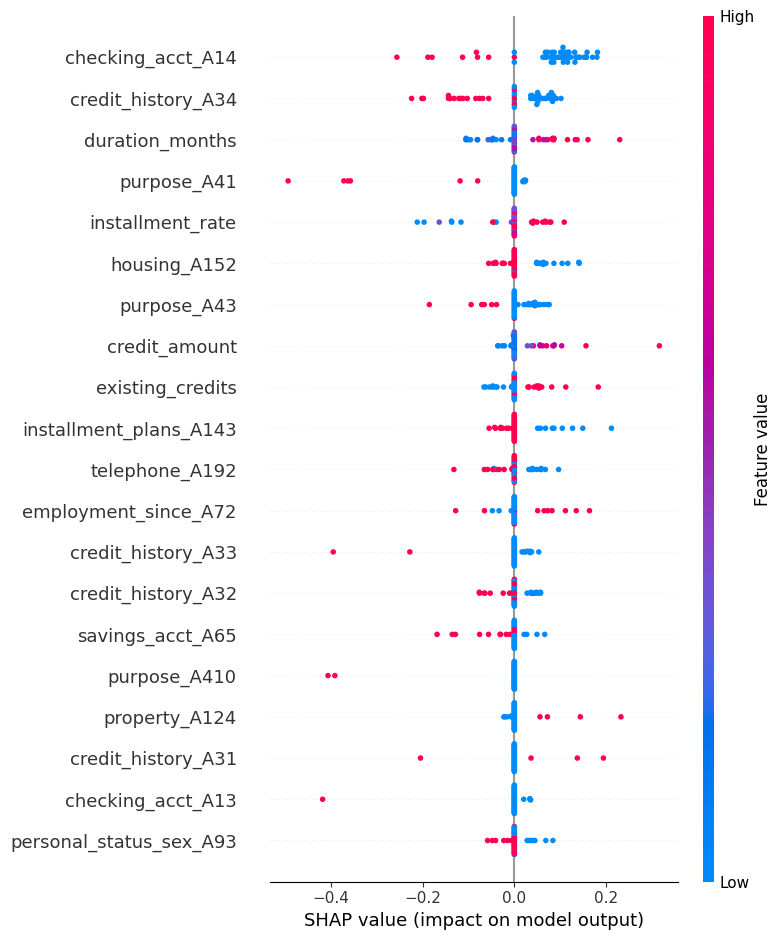

In [74]:
#Plotting of SHAP feature importance
feature_names = X_ohe.columns.tolist()

shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    show=True
)

### Interpretation (SHAP)

The plot above is the standard way of summarizing feature importance with feature effects (beeswarm plot).

Each point is a Shapley value for a feature and an applicant. The X-axis shows Shap values, which is another way of saying "the contribution of each feature to the game's payout or prediction". Remember, SHAP is based on game theory and basically simulates different games to observe their outcomes. The Y-axis ranks features by overall importance, across all combinations.

The color represents the feature's value, in this case blue (for low) and pink/red (for high). One of the most important aspects of the summary plot is the horizontal position (left/right), since it is not about feature importance, but about the direction of each individual prediction. For example, a low value of a feature may push one applicant toward approval (negative SHAP), but then push toward decline for another (positive SHAP). Based on the plot, we can see:

- **checking_acct_A14** is the most important, with low values pushing toward decline (right side, positive SHAP).
- **credit_history_A34** shows credit history (critical/other credits) also one of the most important. High values (red) favor approval.
- **duration_months** shows that longer credits (high values, red) favor decline, compared to shorter ones (low values, blue).
- **purpose_A41** shows uneven effects and distribution (loan purpose:buying a used car), with high values pushing toward decline with more variation, whereas low values tend to cluster and favor approval.
- **credit_amount** shows that as the requested credit amount increases, SHAP values (red) toward decline also increase.

Interestingly, some features that are less present or prominent in other XAI methods, such as **telephone_A192** (having one), **residence_since** (length of having rented one's place) and **housing_A152** (housing status), appear in the 20 most relevant, whereas others, such as **foreign_worker** or **debtor**, do not.


In [75]:
X_test_sample = pd.DataFrame(
    X_test_sample,
    columns=X_ohe.columns   # IMPORTANT: same columns as training
)

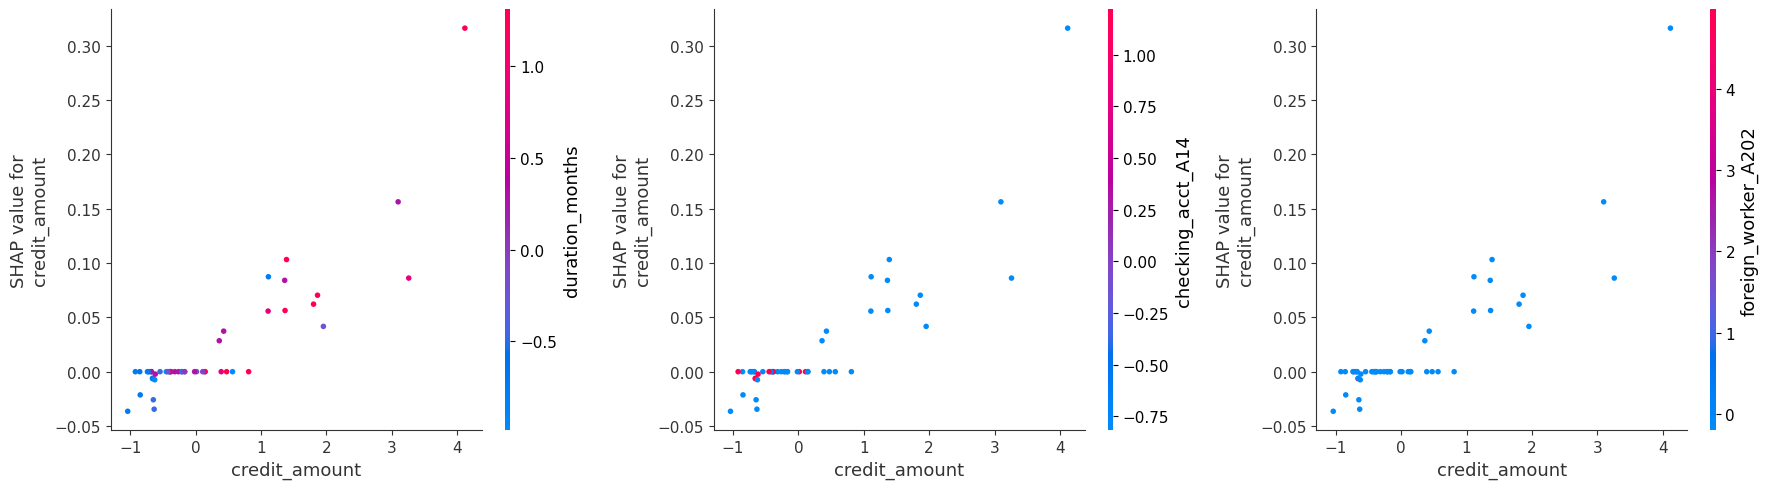

In [76]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

shap.dependence_plot(
    "credit_amount",
    shap_values,
    X_test_sample,
    interaction_index="duration_months",
    ax=axes[0],
    show=False
)

shap.dependence_plot(
    "credit_amount",
    shap_values,
    X_test_sample,
    interaction_index="checking_acct_A14",
    ax=axes[1],
    show=False
)

shap.dependence_plot(
    "credit_amount",
    shap_values,
    X_test_sample,
    interaction_index="foreign_worker_A202",
    ax=axes[2],
    show=False
)

plt.tight_layout()
plt.show()

In [77]:
checking_counts = X_ohe['checking_acct_A14'].value_counts().sort_index()
print(checking_counts)

checking_acct_A14
0.0    606
1.0    394
Name: count, dtype: int64


In [78]:
foreign_counts = X_ohe['foreign_worker_A202'].value_counts().sort_index()
print(foreign_counts)

foreign_worker_A202
0.0    963
1.0     37
Name: count, dtype: int64


Lastly, the SHAP feature dependence plots above provide a global overview of how a few of the most important selected features influence the model's predictions, offering nuances and caveats to consider for auditing and explainability purposes.

The *first takeaway* is that the most dominant features (globally) follow a standard credit risk story: higher requested credit or loans amounts, for a longer period of time, will receive higher SHAP values and push the model toward decline.

The *second takeaway* is concerned with potential biases and data limitations. The dependence plot allows us to see two relevant bias aspects: there is an imbalance in the number of applicants with no checking account (checking_acct_A14) and, more notably, less than 100 foreign workers requesting credit (foreign_worker_A202). As a result, our FFNN may be missing these patterns as it is not trained to behave predictably for groups which may have lower financial savings or who are underrepresented.

<a name="conclusion"></a>
# Conclusion & Limitations

Overall, our findings point to how explainability methods can challenge and help us refine assumptions and conclusions about data use, model behavior, and the predictions of black box models in choices affecting society. In the context of credit assignment, these apply to global patterns, where the majority of applicants in Germany may be accepted for a loan. Local interpretations also support the premise that those who are part of underrepresented groups, such as those with limited financial history or part of a minority, may require stronger, more precise evaluations to account for variations in the distrubution.

More broadly, human interpretability and oversight are central to the responsible use of data science in public policy contexts. Explanations must clarify both how a model arrives at a prediction and why specific factors drive that outcome. Whenever feasible, inherently interpretable models should be preferred. When performance requirements necessitate the use of black-box models, their deployment must be accompanied by rigorous, continuous evaluation of explainability and fairness—or reconsidered altogether in settings where accountability cannot be ensured.

This tutorial is focused on education and learning. We acknowledge that it is in no way conclusive with respect to all available XAI methods. While we do not claim exhaustive coverage, our goal is to foster a foundational understanding of key model-agnostic methods and demonstrate their practical application. We hope this serves as a  starting point for further exploration into the thought process and workflow needed for responsible AI and tech development.

<a name="references"></a>
# References



### Readings

This tutorial is largely based on [Christoph Molnar's book (2025)](https://christophm.github.io/interpretable-ml-book/). We therefore wholehartedly recommend it to any avid learner wanting to explore more aspects of xAI. It goes way beyond the scope of this tutorial and is therefore a great resource for further learning.

For ease of readability we used hyperlinks where possible to link to the cited resources.

### Documentation

- [Positive Weights in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)
- [LIME](https://christophm.github.io/interpretable-ml-book/lime.html)
- [DiCE](https://interpret.ml/DiCE/)
- [Shapley Values in ML](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP](https://shap.readthedocs.io/en/latest/)
